# 如何训练脑启发式模型？

**目标**：在本指南结束时，您将能够训练霍普菲尔德网络使用海布学习来存储和回忆模式。

**预计阅读时间**：12 分钟

---

## 介绍

与使用反向传播训练的深度学习模型不同，**脑启发式模型**使用生物学上合理的学习规则，如**Hebbian Learning**：

本指南介绍：
1. Hebbian Learning原理
2. 为模式记忆训练霍普菲尔德网络
3. 使用训练器框架
4. 与深度学习的关键差异

我们将训练一个模型来记忆和回忆图像——展示联想记忆的实际应用。

## 什么是Hebbian Learning？

**Hebbian Learning**是一种无监督学习规则，当突触前和突触后神经元共同活跃时，突触权重增强：

```
Δw_ij = η × x_i × x_j
```

其中：
- `w_ij`：从神经元 `i` 到神经元 `j` 的连接权重
- `x_i, x_j`：神经元 `i` 和 `j` 的活动
- `η`：学习率（对于简单规则，通常设置为 1）

**关键特性**：
- **局部**：权重更新仅取决于连接神经元的活动（没有全局错误信号）
- **无监督**：不需要标签或目标输出
- **生物学上合理**：与真实神经元中观察到的突触可塑性相匹配

**与反向传播的对比**：
- 反向传播：全局错误信号、有监督、需要可微分的损失
- 海布学习：局部活动、无监督、无梯度计算

## Amari-Hopfield 网络

**Amari-Hopfield 网络**是一个递归网络，将模式存储为稳定的吸引子状态。当呈现部分或噪声模式时，网络收敛到最近的存储记忆。

**用例**：联想记忆、模式补全、错误纠正


In [ ]:
from canns.models.brain_inspired import AmariHopfieldNetwork

# 创建一个包含 16,384 个神经元的 Amari-Hopfield 网络（128x128 展平图像）
model = AmariHopfieldNetwork(
    num_neurons=128 * 128,  # 展平后的图像大小
    asyn=False,             # 同步更新（所有神经元一起更新）
    activation="sign"       # 二进制激活：+1 或 -1
)

**参数**：
- `num_neurons`：网络大小（必须匹配输入维度）
- `asyn`：异步（一次一个神经元）对比同步更新
- `activation`：用于二进制霍普菲尔德的"sign"，用于连续变体的"tanh"

## 训练器框架

该库提供了一个**统一的训练器 API** 来抽象训练逻辑：

```
模型 + 训练器 + 数据 → 训练后的模型
```

**设计理念**（来自设计哲学文档）：
- **关注点分离**：模型定义动力学，训练器定义学习
- **可重用性**：相同的训练器适用于具有兼容学习规则的不同模型
- **可组合性**：堆叠训练器进行多阶段训练

对于海布学习，我们使用 `HebbianTrainer`：


In [5]:
from canns.trainer import HebbianTrainer

trainer = HebbianTrainer(model)

**关键方法**：
- `trainer.train(data)`：在模式列表上训练
- `trainer.predict(pattern)`：回忆单个模式
- `trainer.predict_batch(patterns)`：批处理回忆（为速度编译）

## 完整示例：图像记忆

让我们训练一个霍普菲尔德网络来记忆 4 张图像，并从损坏的版本中回忆它们。

### 步骤 1：准备训练数据


In [6]:
import numpy as np
import skimage.data
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.filters import threshold_mean

def preprocess_image(img, size=128):
    """将图像转换为二进制 {-1, +1} 模式。"""
    # 如果需要转换为灰度
    if img.ndim == 3:
        img = rgb2gray(img)

    # 调整为固定大小
    img = resize(img, (size, size), anti_aliasing=True)

    # 阈值化为二进制
    thresh = threshold_mean(img)
    binary = img > thresh

    # 映射到 {-1, +1}
    pattern = np.where(binary, 1.0, -1.0).astype(np.float32)

    # 展平为 1D
    return pattern.reshape(size * size)

# 从 scikit-image 加载示例图像
camera = preprocess_image(skimage.data.camera())
astronaut = preprocess_image(skimage.data.astronaut())
horse = preprocess_image(skimage.data.horse().astype(np.float32))
coffee = preprocess_image(skimage.data.coffee())

training_data = [camera, astronaut, horse, coffee]

print(f"模式数量：{len(training_data)}")
print(f"模式形状：{training_data[0].shape}")  # (16384,) = 128*128

模式数量：4
模式形状：(16384,)


**为什么是二进制 {-1, +1}？**
- 经典霍普菲尔德网络使用二进制神经元
- 简化能量函数和更新规则
- 实值扩展存在（使用 `activation="tanh"`）

### 步骤 2：创建模型和训练器


In [7]:
from canns.models.brain_inspired import AmariHopfieldNetwork
from canns.trainer import HebbianTrainer

# 创建霍普菲尔德网络
model = AmariHopfieldNetwork(
    num_neurons=training_data[0].shape[0],
    asyn=False,
    activation="sign"
)

# 创建海布训练器
trainer = HebbianTrainer(model)

print("模型和训练器已初始化！")

模型和训练器已初始化！


### 步骤 3：训练模型


In [8]:
# 在所有模式上训练（这计算海布权重矩阵）
trainer.train(training_data)

print("训练完成！模式已存储在权重中。")

训练完成！模式已存储在权重中。


**内部发生的事**：


In [ ]:
# 海布权重更新的简化版本
for pattern in training_data:
    W += np.outer(pattern, pattern)  # 海布：w_ij += x_i * x_j
W /= len(training_data)  # 归一化
np.fill_diagonal(W, 0)   # 无自连接

权重矩阵 `W` 现在将所有训练模式编码为吸引子状态。

### 步骤 4：测试模式回忆

创建训练图像的损坏版本：


In [10]:
def corrupt_pattern(pattern, noise_level=0.3):
    """随机翻转 30% 的像素。"""
    corrupted = np.copy(pattern)
    num_flips = int(len(pattern) * noise_level)
    flip_indices = np.random.choice(len(pattern), num_flips, replace=False)
    corrupted[flip_indices] *= -1  # 翻转符号
    return corrupted

# 创建测试模式（30% 损坏）
test_patterns = [corrupt_pattern(p, 0.3) for p in training_data]

print(f"创建了 {len(test_patterns)} 个损坏的测试模式")

创建了 4 个损坏的测试模式


### 步骤 5：回忆模式


In [11]:
# 批处理预测（为效率而编译）
recalled = trainer.predict_batch(test_patterns, show_sample_progress=True)

print("模式回忆完成！")
print(f"回忆模式形状：{np.array(recalled).shape}")

Processing samples: 100%|█████████████| 4/4 [00:03<00:00,  1.08it/s, sample=4/4]


模式回忆完成！
回忆模式形状：(4, 16384)


**发生了什么**：
- 对于每个损坏的模式，网络迭代其动力学
- 活动收敛到最近的存储吸引子（原始图像）
- 结果是"清理过"的模式

### 步骤 6：可视化结果


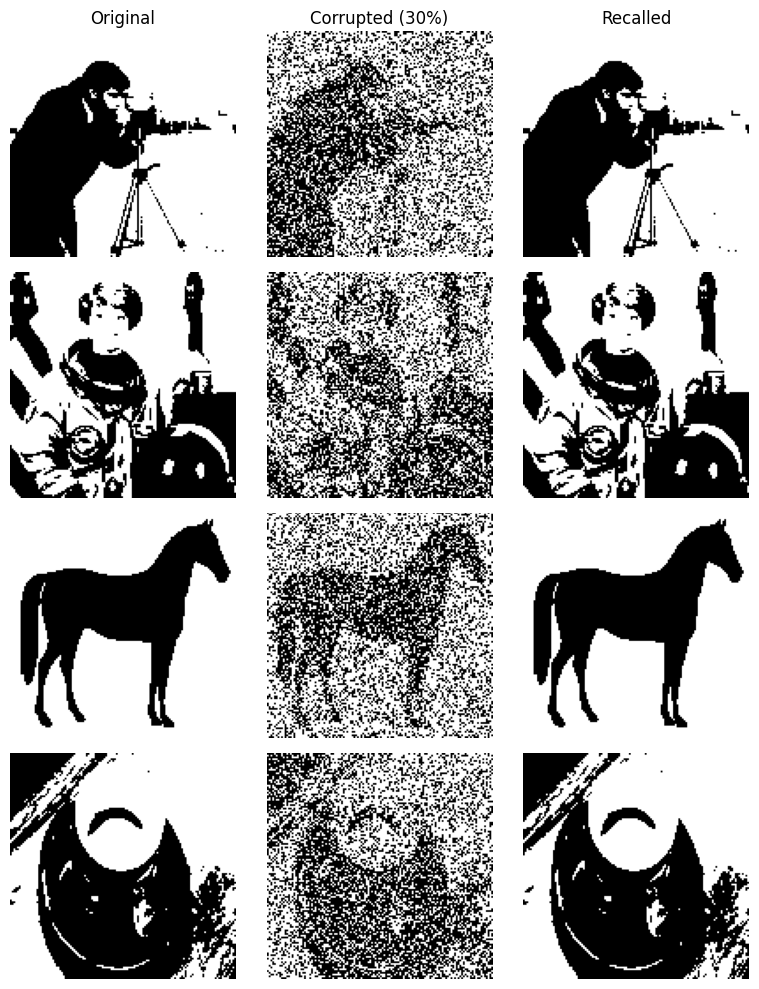

可视化已保存！


In [13]:
import matplotlib.pyplot as plt

def reshape_for_display(pattern, size=128):
    """将 1D 模式重塑为 2D 图像。"""
    return pattern.reshape(size, size)

# 绘制原始、损坏和回忆的模式
fig, axes = plt.subplots(len(training_data), 3, figsize=(8, 10))

for i in range(len(training_data)):
    # 第 1 列：原始训练图像
    axes[i, 0].imshow(reshape_for_display(training_data[i]), cmap='gray')
    axes[i, 0].axis('off')
    if i == 0:
        axes[i, 0].set_title('Original')

    # 第 2 列：损坏的测试输入
    axes[i, 1].imshow(reshape_for_display(test_patterns[i]), cmap='gray')
    axes[i, 1].axis('off')
    if i == 0:
        axes[i, 1].set_title('Corrupted (30%)')

    # 第 3 列：回忆的输出
    axes[i, 2].imshow(reshape_for_display(recalled[i]), cmap='gray')
    axes[i, 2].axis('off')
    if i == 0:
        axes[i, 2].set_title('Recalled')

plt.tight_layout()
plt.savefig('hopfield_memory_recall.png', dpi=150)
plt.show()

print("可视化已保存！")

**预期结果**：
- 原始图像是干净的
- 损坏的输入有约 30% 的噪声
- 回忆的输出与原始相匹配（噪声已纠正！）

## 完整可运行代码

这是一个块中的完整示例：


In [ ]:
import numpy as np
import skimage.data
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.filters import threshold_mean
from matplotlib import pyplot as plt

from canns.models.brain_inspired import AmariHopfieldNetwork
from canns.trainer import HebbianTrainer

np.random.seed(42)

# 1. 预处理图像
def preprocess_image(img, size=128):
    if img.ndim == 3:
        img = rgb2gray(img)
    img = resize(img, (size, size), anti_aliasing=True)
    thresh = threshold_mean(img)
    binary = img > thresh
    pattern = np.where(binary, 1.0, -1.0).astype(np.float32)
    return pattern.reshape(size * size)

camera = preprocess_image(skimage.data.camera())
astronaut = preprocess_image(skimage.data.astronaut())
horse = preprocess_image(skimage.data.horse().astype(np.float32))
coffee = preprocess_image(skimage.data.coffee())

training_data = [camera, astronaut, horse, coffee]

# 2. 创建模型和训练器
model = AmariHopfieldNetwork(num_neurons=training_data[0].shape[0], asyn=False, activation="sign")
trainer = HebbianTrainer(model)

# 3. 训练
trainer.train(training_data)

# 4. 创建损坏的测试模式
def corrupt_pattern(pattern, noise_level=0.3):
    corrupted = np.copy(pattern)
    num_flips = int(len(pattern) * noise_level)
    flip_indices = np.random.choice(len(pattern), num_flips, replace=False)
    corrupted[flip_indices] *= -1
    return corrupted

test_patterns = [corrupt_pattern(p, 0.3) for p in training_data]

# 5. 回忆模式
recalled = trainer.predict_batch(test_patterns, show_sample_progress=True)

# 6. 可视化
def reshape(pattern, size=128):
    return pattern.reshape(size, size)

fig, axes = plt.subplots(len(training_data), 3, figsize=(8, 10))
for i in range(len(training_data)):
    axes[i, 0].imshow(reshape(training_data[i]), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(reshape(test_patterns[i]), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(reshape(recalled[i]), cmap='gray')
    axes[i, 2].axis('off')

axes[0, 0].set_title('原始')
axes[0, 1].set_title('损坏')
axes[0, 2].set_title('回忆')

plt.tight_layout()
plt.savefig('hopfield_memory.png')
plt.show()

## CANN 对比深度学习训练

| 方面 | Hebbian Learning | 深度学习 (ANN) |
|--------|-------------------------|----------------------|
| **学习规则** | 局部（海布、STDP） | 全局（反向传播） |
| **监督** | 无监督 | 有监督（通常） |
| **梯度** | 无梯度计算 | 需要自动微分 |
| **训练数据** | 要记忆的模式 | 标记的输入-输出对 |
| **目标** | 形成吸引子 | 最小化损失函数 |
| **生物学合理性** | 高 | 低 |
| **速度** | 快（可能的一次学习） | 慢（许多周期） |
| **容量** | 有限（N 个神经元约 0.15N 个模式） | 非常大（过参数化） |

**何时使用各个**：
- **Hebbian Learning**：联想记忆、模式补全、神经科学建模
- **反向传播 / ANN**：分类、回归、大规模模式识别

## 训练器抽象

`Trainer` 框架跨不同学习范式提供一致的接口：


In [ ]:
# 所有训练器都遵循此模式
trainer = SomeTrainer(model)
trainer.train(data)
output = trainer.predict(input)

**可用的训练器**：
- `HebbianTrainer`：海布学习（如这里所示）
- 未来训练器：STDP、BCM、强化学习等

**为什么这样设计？**
- **模块性**：交换学习规则而不改变模型代码
- **一致性**：不同学习算法的相同 API
- **可扩展性**：轻松添加自定义训练器

有关此架构的更多详细信息，请参阅设计哲学文档。

## 后续步骤

恭喜！您已使用海布学习训练了脑启发式模型。现在探索：

1. **[核心概念](link-to-core-concepts)** - 深化对所有库组件的理解
2. **[脑启发式训练](link-to-core-concepts-training)** - 了解其他学习规则（STDP、BCM 等）
3. **[完整训练器 API](link-to-full-details-training)** - 所有训练器和训练方法的完整参考

---

**快速参考**：


In [ ]:
# Hebbian Learning模板
from canns.models.brain_inspired import AmariHopfieldNetwork
from canns.trainer import HebbianTrainer

# 创建模型
model = AmariHopfieldNetwork(num_neurons=N, activation="sign")

# 创建训练器
trainer = HebbianTrainer(model)

# 在模式上训练
trainer.train([pattern1, pattern2, ...])

# 回忆
output = trainer.predict(noisy_input)

---

*有问题？查看 [训练器框架指南](link-to-core-concepts-trainer) 或 [GitHub 讨论](https://github.com/routhleck/canns/discussions)。*